# Air quality

### Importing dataset

In [58]:
import pandas as pd
df = pd.read_csv("air1.csv")

### Data cleaning and manipulation

In [59]:
df = df.drop(columns=["Message"])
df.columns = ["id", "pollutant_code", "pollutant", "measure_type", "unit",
              "cd_code", "location_code", "location", "period", "start_date", "value"]
print(df.head())

       id  pollutant_code               pollutant measure_type unit cd_code  \
0  336867             375  Nitrogen dioxide (NO2)         Mean  ppb      CD   
1  336741             375  Nitrogen dioxide (NO2)         Mean  ppb      CD   
2  550157             375  Nitrogen dioxide (NO2)         Mean  ppb      CD   
3  412802             375  Nitrogen dioxide (NO2)         Mean  ppb      CD   
4  412803             375  Nitrogen dioxide (NO2)         Mean  ppb      CD   

   location_code                           location               period  \
0            407      Flushing and Whitestone (CD7)       Winter 2014-15   
1            107              Upper West Side (CD7)       Winter 2014-15   
2            414  Rockaway and Broad Channel (CD14)  Annual Average 2017   
3            407      Flushing and Whitestone (CD7)       Winter 2015-16   
4            407      Flushing and Whitestone (CD7)          Summer 2016   

  start_date  value  
0  12/1/2014  23.97  
1  12/1/2014  27.42  
2 

In [60]:
df["date"] = pd.to_datetime(df["start_date"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")


In [61]:
missing = df.isna().sum()
print(missing)

id                0
pollutant_code    0
pollutant         0
measure_type      0
unit              0
cd_code           0
location_code     0
location          0
period            0
start_date        0
value             0
date              0
dtype: int64


In [ ]:
before = df.shape[0]

df = df.dropna()

after = df.shape[0]
dropped = before - after

print(f"Rows dropped: {dropped}")


Rows dropped: 0


This code calculates how many rows were removed from the DataFrame after dropping all rows containing missing values (NaN). It helps to understand the impact of cleaning the dataset on its size.
Since the output was 0, it means that there were no rows with missing values in the DataFrame, so no rows were dropped during the `dropna()` operation.

In [ ]:
df["year"] = df["period"].str.extract(r"(\d{4})").astype(int)

df["season"] = df["period"].str.extract(r"(Winter|Summer|Annual)", expand=False)

print(df[["period", "year", "season"]].head())

                period  year  season
0       Winter 2014-15  2014  Winter
1       Winter 2014-15  2014  Winter
2  Annual Average 2017  2017  Annual
3       Winter 2015-16  2015  Winter
4          Summer 2016  2016  Summer


This code extracts specific year and season from a time perios, which will be useful in further analysis.

In [82]:
df["pollutant"] = df["pollutant"].str.replace("Fine particles \\(PM 2.5\\)", "PM2.5", regex=True)
df["pollutant"] = df["pollutant"].str.replace("Nitrogen dioxide \\(NO2\\)", "NO2", regex=True)

In [81]:
pm25_only = df[df["pollutant"] == "PM2.5"]
no2_only = df[df["pollutant"] == "NO2"]

In [ ]:
selected_pollutants = [
    'NO2', 'PM2.5', 'Boiler Emissions - Total SO2 Emissions', 'Ozone (O3)',
    'Boiler Emissions - Total NOx Emissions', 'Boiler Emissions - Total PM2.5 Emissions',
    'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene',
]

pollutants_df = df[df['pollutant'].isin(selected_pollutants)]


selected_plot_df = pollutants_df[['pollutant', 'year', 'value', 'location_code']].copy()

Creating a dataframe containing specifically different pollutants.

In [ ]:
seasonal_pollutants = [
    'NO2', 'PM2.5',
]

seasonal_df = df[df['pollutant'].isin(seasonal_pollutants)]

seasonal_plot_df = seasonal_df[['pollutant', 'season', 'value', 'year']].copy()

Creating a df with seasonal pollutants, we only have seasonal measurements for no2 and pm2.5
Ozone has measurements only for summer

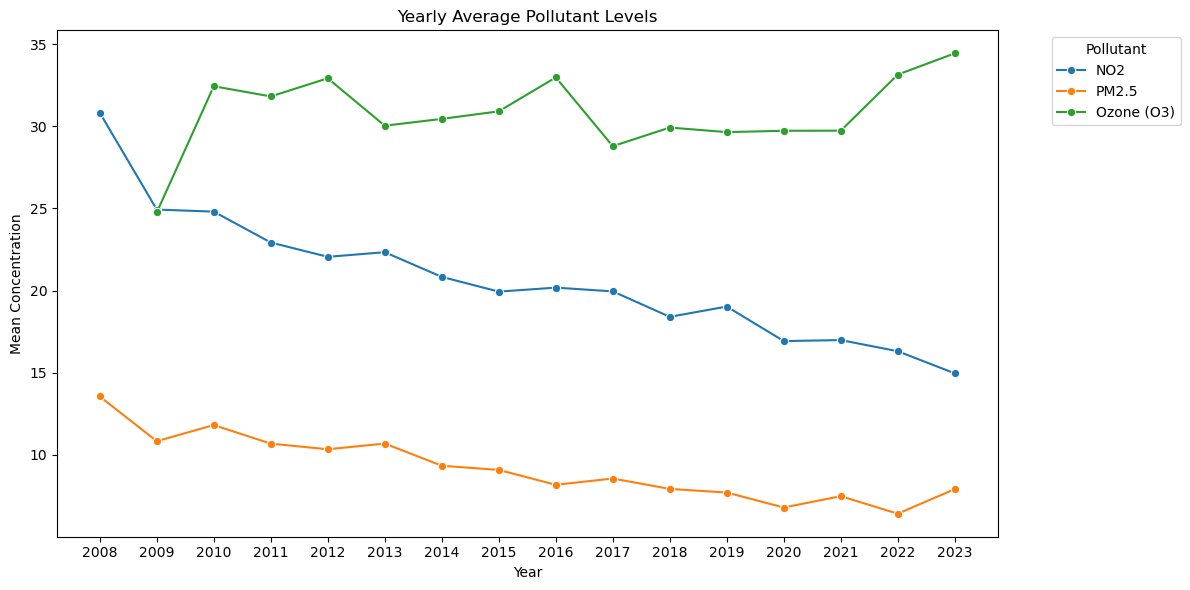

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

toxics = ['Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']

filtered_df = selected_plot_df[
    (selected_plot_df['year'] >= 2008) &
    (~selected_plot_df['pollutant'].isin(toxics))
]

grouped = filtered_df.groupby(['year', 'pollutant'])['value'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='year', y='value', hue='pollutant', marker='o')
plt.title("Yearly Average Pollutant Levels")
plt.xlabel("Year")
plt.ylabel("Mean Concentration")
plt.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(sorted(grouped['year'].unique()))
plt.tight_layout()
plt.show()


This line graph offers a clear depiction of yearly average pollutant levels from 2008 to 2023, showcasing distinct trends for each substance. We can observe a consistent and encouraging downward trend in NO2 concentrations across the entire period. Similarly, PM2.5 levels, while experiencing minor fluctuations, also show a general decreasing trend from their initial values in 2008 to 2023. In contrast, a significant area of concern arises with Ozone (O3) levels, which exhibit notable variability but ultimately display a worrying upward trajectory in recent years, culminating in O3 becoming the highest concentration pollutant by 2023. 

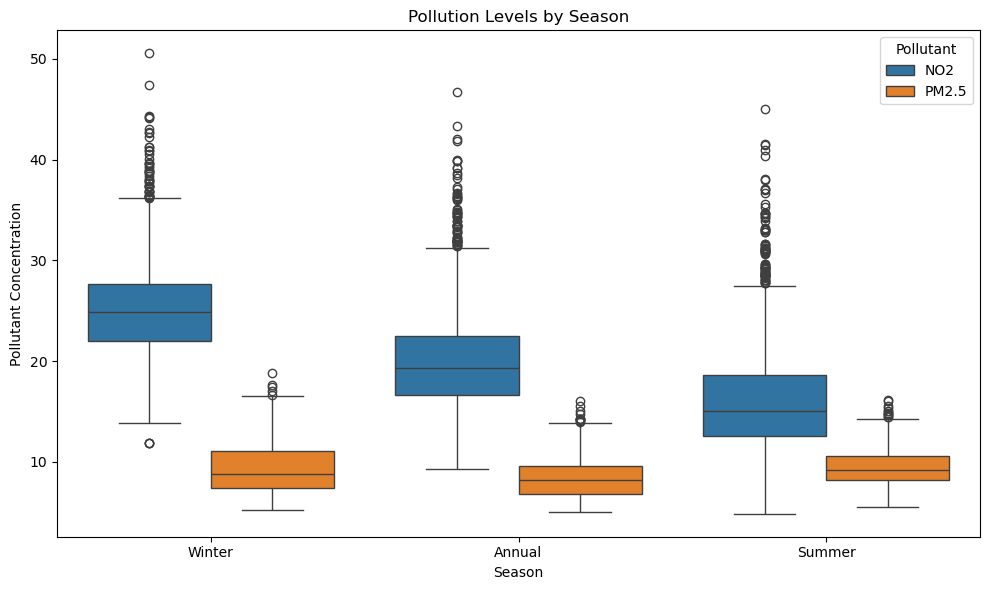

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=seasonal_plot_df, x="season", y="value", hue="pollutant")
plt.title("Pollution Levels by Season")
plt.ylabel("Pollutant Concentration")
plt.xlabel("Season")
plt.legend(title="Pollutant")
plt.tight_layout()
plt.show()


Winter has elevated NO2 levels: This could be attributed to factors like increased heating activities (burning of fossil fuels) and potentially less atmospheric dispersion due to weather conditions (e.g., temperature inversions).
Summer has lower pollution levels: Warmer weather often leads to better atmospheric mixing and dispersion of pollutants. Reduced heating needs also contribute to lower emissions.
PM2.5 follows a similar but less pronounced seasonal pattern: While PM2.5 levels are generally lower than NO2, they also tend to be higher in winter and lower in summer.

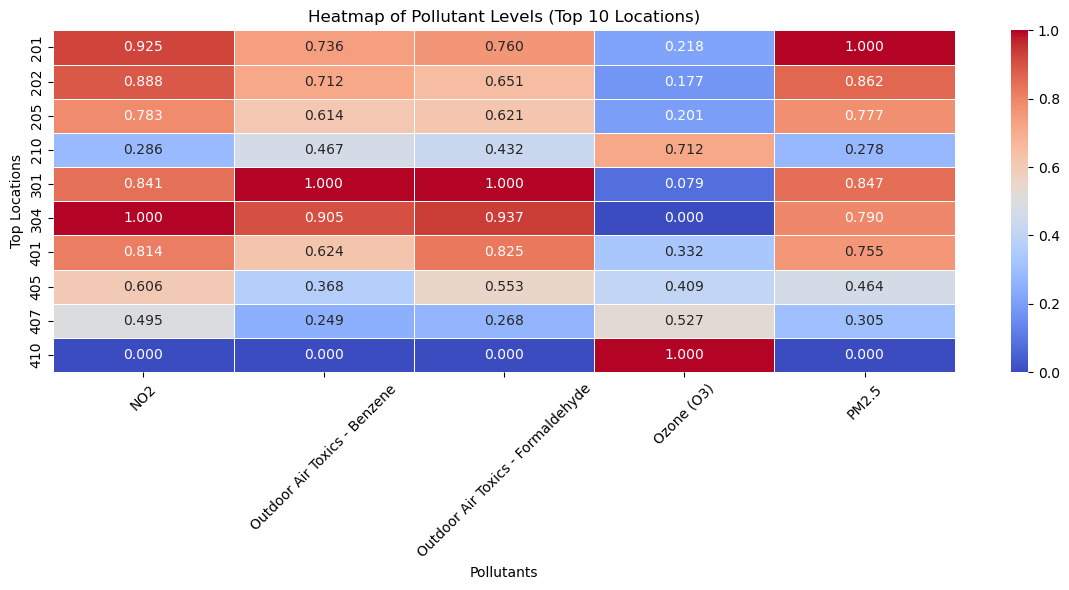

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

top_locations = selected_plot_df['location_code'].value_counts().head(10).index

filtered_df = selected_plot_df[selected_plot_df['location_code'].isin(top_locations)]

heatmap_data = filtered_df.pivot_table(values='value', 
                                       index='location_code', 
                                       columns='pollutant', 
                                       aggfunc='mean')

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(heatmap_data)
normalized_df = pd.DataFrame(normalized_data, index=heatmap_data.index, columns=heatmap_data.columns)

plt.figure(figsize=(12, 6))
sns.heatmap(normalized_df, cmap="coolwarm", annot=True, fmt=".3f", linewidths=0.5)
plt.title('Heatmap of Pollutant Levels (Top 10 Locations)')
plt.xlabel('Pollutants')
plt.ylabel('Top Locations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#change the nrs to location 1 2 3 etc
#change it to for example summer 2015 because having a mean doesnt rly make sense

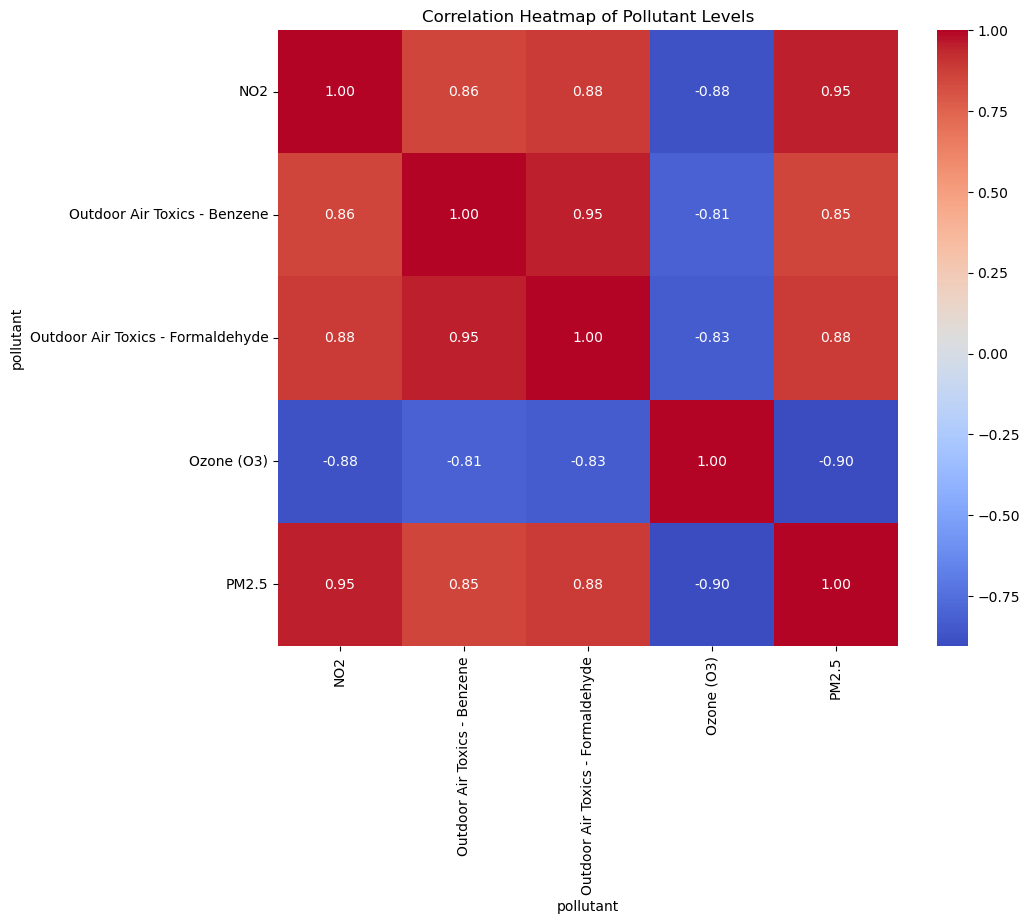

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = selected_plot_df.pivot_table(index='location_code', columns='pollutant', values='value')

correlation_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Pollutant Levels')
plt.show()


This correlation heatmap, titled "Correlation Heatmap of Pollutant Levels," illustrates the linear relationships between different pollutants. A striking observation is the strong positive correlation (indicated by warm colors and values close to 1.00) among NO2, Outdoor Air Toxics (Benzene and Formaldehyde), and PM2.5, suggesting these pollutants often increase or decrease together. Conversely, Ozone (O3) exhibits a strong negative correlation (indicated by cool colors and values close to -1.00) with all other pollutants, meaning that as O3 levels increase, the levels of NO2, Benzene, Formaldehyde, and PM2.5 tend to decrease, and vice-versa. This inverse relationship for Ozone highlights distinct atmospheric chemistry or source characteristics compared to the other measured pollutants.

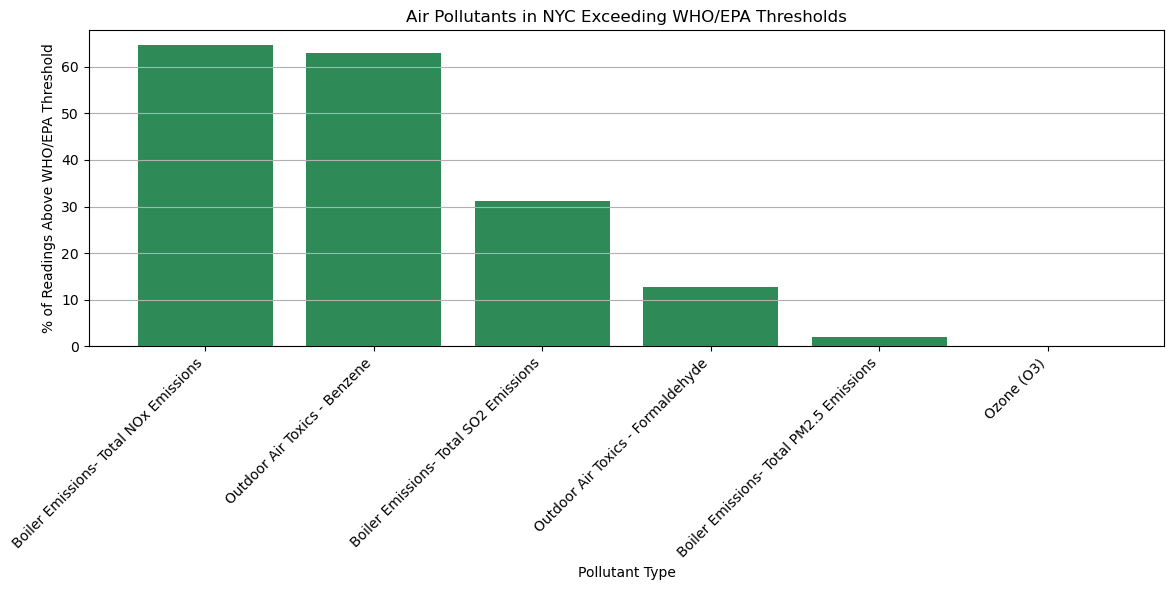

                                 pollutant  exceedance_rate
0    Boiler Emissions- Total NOx Emissions        64.583333
3             Outdoor Air Toxics - Benzene        63.054187
2    Boiler Emissions- Total SO2 Emissions        31.250000
4        Outdoor Air Toxics - Formaldehyde        12.807882
1  Boiler Emissions- Total PM2.5 Emissions         2.083333
5                               Ozone (O3)         0.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


thresholds = {
    'Nitrogen dioxide (NO2)': 21,                
    'Fine particles (PM 2.5)': 10,                 
    'Ozone (O3)': 50,                            
    'Boiler Emissions- Total SO2 Emissions': 8,          
    'Boiler Emissions- Total NOx Emissions': 21,
    'Boiler Emissions- Total PM2.5 Emissions': 10,
    'Outdoor Air Toxics - Formaldehyde': 3,     
    'Outdoor Air Toxics - Benzene': 1.3         
}

df_filtered = df[df['pollutant'].isin(thresholds.keys())].copy()

df_filtered['above_threshold'] = df_filtered.apply(
    lambda row: row['value'] > thresholds.get(row['pollutant'], float('inf')),
    axis=1
)

summary = (
    df_filtered.groupby('pollutant')['above_threshold']
    .mean()
    .reset_index()
    .rename(columns={'above_threshold': 'exceedance_rate'})
)
summary['exceedance_rate'] *= 100
summary.sort_values('exceedance_rate', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(summary['pollutant'], summary['exceedance_rate'], color='seagreen')
plt.ylabel('% of Readings Above WHO Treshold')
plt.xlabel('Pollutant Type')
plt.title('Air Pollutants in NYC Exceeding WHO/EPA Thresholds')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

print(summary)


This bar chart presents the percentage of readings for various pollutant types in New York City that exceeded established World Health Organization (WHO) thresholds. It clearly indicates that "Boiler Emissions - Total NOx Emissions" and "Outdoor Air Toxics - Benzene" are the most significant concerns, with well over 60% of their readings surpassing the recommended limits. "Boiler Emissions - Total SO2 Emissions" also shows a substantial exceedance rate of over 50%. In contrast, "Outdoor Air Toxics - Formaldehyde" and "Boiler Emissions - Total PM2.5 Emissions" show much lower percentages of exceedance, while "Ozone (O3)" registers almost no readings above the thresholds. This visualization effectively pinpoints which air pollutants in NYC are most frequently at concerning levels according to international and national health standards.

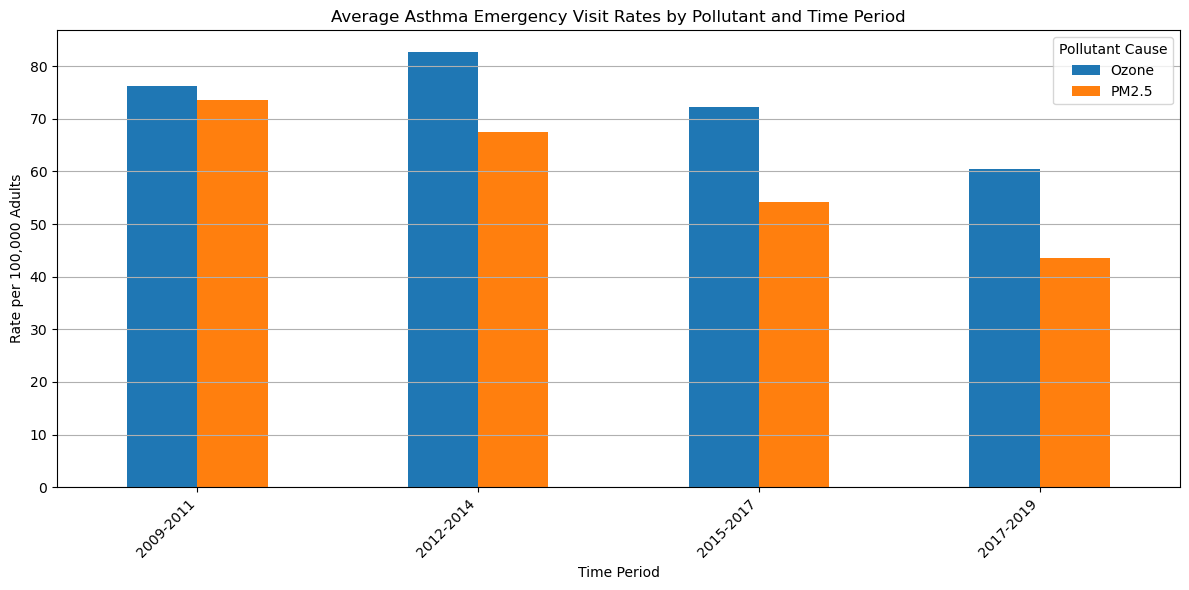

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

asthma_df = df[df['pollutant'].isin([
    'Asthma emergency department visits due to PM2.5',
    'Asthma emergency departments visits due to Ozone'
])].copy()

asthma_df['Pollutant Cause'] = asthma_df['pollutant'].map({
    'Asthma emergency department visits due to PM2.5': 'PM2.5',
    'Asthma emergency departments visits due to Ozone': 'Ozone'
})

grouped = (
    asthma_df.groupby(['period', 'Pollutant Cause'])['value']
    .mean()
    .unstack()
    .fillna(0)
    .sort_index()
)

grouped = grouped[~grouped.index.str.contains("2005-2007")]

grouped.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])

plt.title('Average Asthma Emergency Visit Rates by Pollutant and Time Period')
plt.xlabel('Time Period')
plt.ylabel('Rate per 100,000 Adults')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Pollutant Cause')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


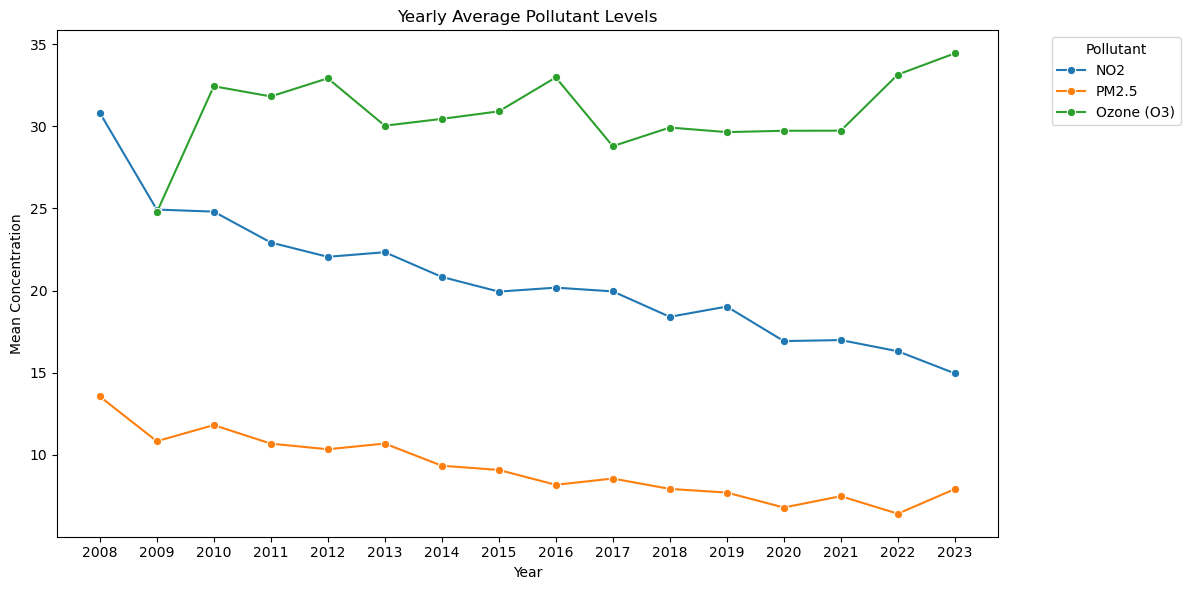

The top graph, "Average Asthma Emergency Visit Rates by Pollutant and Time Period," illustrates the impact of Ozone and PM2.5 on asthma emergency visits in NYC across several timeframes. We observe that both pollutants contribute to these visits, with a notable peak in the 2012-2014 period for both, and Ozone consistently linked to slightly higher rates. However, a significant positive trend is visible as asthma emergency visits associated with both pollutants show a clear decline in the later periods, particularly from 2015 to 2019.

This observed decrease in asthma emergency visits for both pollutants can be largely correlated with the trends shown in the "Yearly Average Pollutant Levels" graph below. The consistent overall decrease in average PM2.5 concentrations from 2008 through 2023 directly aligns with the reduction in PM2.5-related asthma visits. While the relationship for Ozone is more complex, as its average levels fluctuate but show an upward trend in recent years, the declining trend in Ozone-related asthma visits in the top graph suggests that other factors, such as public health interventions or improved air quality management, might be mitigating its direct impact on emergency visits despite ambient concentration changes.

C:\Users\oliwv\AppData\Local\Temp\ipykernel_36020\1324076673.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25_only['time_bin'] = pd.cut(pm25_only['year'], bins=bins, labels=labels, right=True)


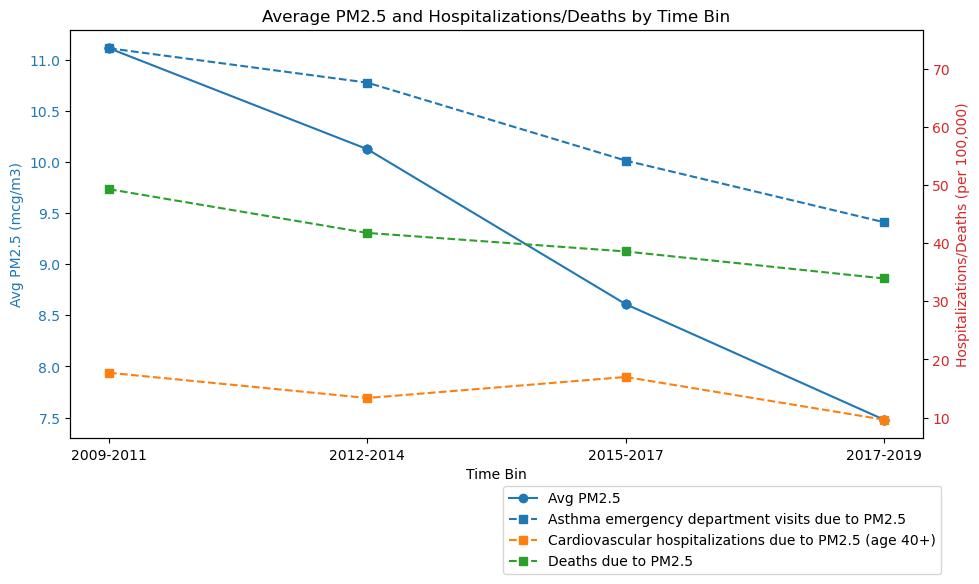

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pm25_repp = [
    'Asthma emergency department visits due to PM2.5',
    'Cardiovascular hospitalizations due to PM2.5 (age 40+)',
    'Deaths due to PM2.5',
]

pm25_repp_df = df[df['pollutant'].isin(pm25_repp)].copy()

pm25_repp_df['time_bin'] = pm25_repp_df['period'].str.strip()

bins = [2008, 2011, 2014, 2017, 2020]
labels = ['2009-2011', '2012-2014', '2015-2017', '2017-2019']

pm25_only['time_bin'] = pd.cut(pm25_only['year'], bins=bins, labels=labels, right=True)

pm25_avg = pm25_only.groupby('time_bin')['value'].mean().reset_index()

pm25_repp_agg = (
    pm25_repp_df.groupby(['pollutant', 'time_bin'])['value']
    .mean()
    .reset_index()
)

merged = pd.merge(pm25_avg, pm25_repp_agg, on='time_bin', how='inner', suffixes=('_pm25', '_hosp'))

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Time Bin')
ax1.set_ylabel('Avg PM2.5 (mcg/m3)', color='tab:blue')
ax1.plot(merged['time_bin'], merged['value_pm25'], marker='o', color='tab:blue', label='Avg PM2.5')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Hospitalizations/Deaths (per 100,000)', color='tab:red')

for pollutant in pm25_repp:
    subset = merged[merged['pollutant'] == pollutant]
    if not subset.empty:
        ax2.plot(subset['time_bin'], subset['value_hosp'], marker='s', linestyle='--', label=pollutant)

ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Average PM2.5 and Hospitalizations/Deaths by Time Period')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.5, -0.1))

fig.tight_layout()
plt.show()

This dual-axis line graph effectively illustrates the relationship between PM2.5 concentrations and various health outcomes in NYC over different time periods. The left y-axis shows the average PM2.5 levels, which exhibit a clear and substantial decrease from 2009-2011 to 2017-2019. Correspondingly, the right y-axis displays rates of asthma emergency department visits, cardiovascular hospitalizations, and deaths attributed to PM2.5.

A significant observation is the strong positive relationship between declining PM2.5 levels and the rates of asthma emergency visits and deaths. As PM2.5 concentrations steadily decreased, so did the number of asthma-related emergency visits and fatalities. While cardiovascular hospitalizations show a less direct correlation, with a slight initial dip followed by a minor increase, the overall trend suggests that reducing PM2.5 pollution has led to positive public health benefits, particularly in mitigating asthma emergencies and mortality.

In [76]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Distribution Plot for NO2 levels
# sns.histplot(seasonal_plot_df[seasonal_plot_df['pollutant'] == 'NO2']['value'], kde=True)
# plt.title('Distribution of NO2 Levels')
# plt.xlabel('NO2 Concentration (ppb)')
# plt.ylabel('Frequency')
# plt.show()


In [77]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# selected_pollutants = [
#     'NO2', 'PM2.5', 'Boiler Emissions - Total SO2 Emissions', 'Ozone (O3)',
#     'Boiler Emissions - Total NOx Emissions', 'Boiler Emissions - Total PM2.5 Emissions',
#     'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene','Annual vehicle miles traveled',
# ]

# # Filter the DataFrame
# plot_df = df[df['pollutant'].isin(selected_pollutants)][['year', 'pollutant', 'value', 'location_code']].copy()


# corr_df = plot_df.pivot_table(index='location_code', columns='pollutant', values='value')

# # Calculate the correlation matrix
# correlation_matrix = corr_df.corr()

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
# plt.title('Correlation Heatmap of Pollutant Levels')
# plt.show()

In [78]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# selected_pollutants = [
#     'NO2', 'PM2.5', 'Boiler Emissions - Total SO2 Emissions', 'Ozone (O3)',
#     'Boiler Emissions - Total NOx Emissions', 'Boiler Emissions - Total PM2.5 Emissions',
#     'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene',
# ]
# # Filter the main dataframe to include only the selected pollutants
# selected_rows = df[df['pollutant_code'] == 643]

# print(selected_rows)

# merged_df = pd.merge(selected_plot_df, selected_rows, on='year')  
# print(merged_df.columns)
# print(merged_df)
# # Set up the plot
# plt.figure(figsize=(14, 10))

# # Create scatter plots for each pollutant
# for i, pollutant in enumerate(selected_pollutants, 1):
#     plt.subplot(3, 3, i)  # Adjust the grid size based on number of pollutants
#     sns.scatterplot(data=merged_df, 
#                     x='value_x', y='value_y', label=pollutant)
#     plt.title(f'{pollutant} vs Traffic Miles')
#     plt.xlabel('Miles of Traffic')
#     plt.ylabel('Pollutant Level')
#     plt.xticks(rotation=45)

# plt.tight_layout()  # Adjust layout for better spacing
# plt.show()


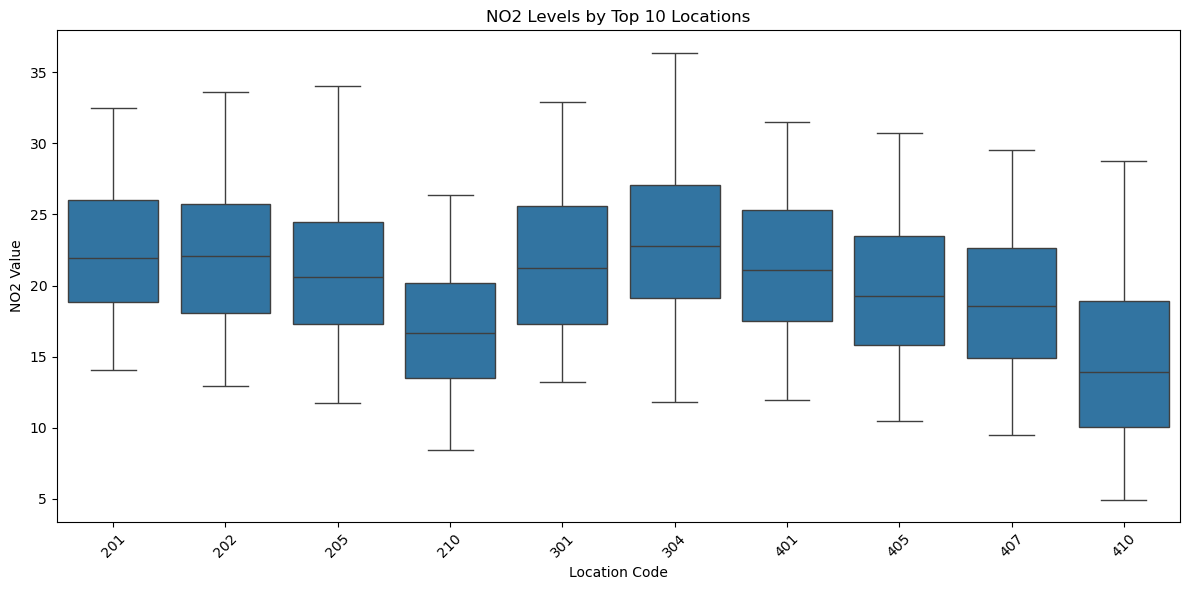

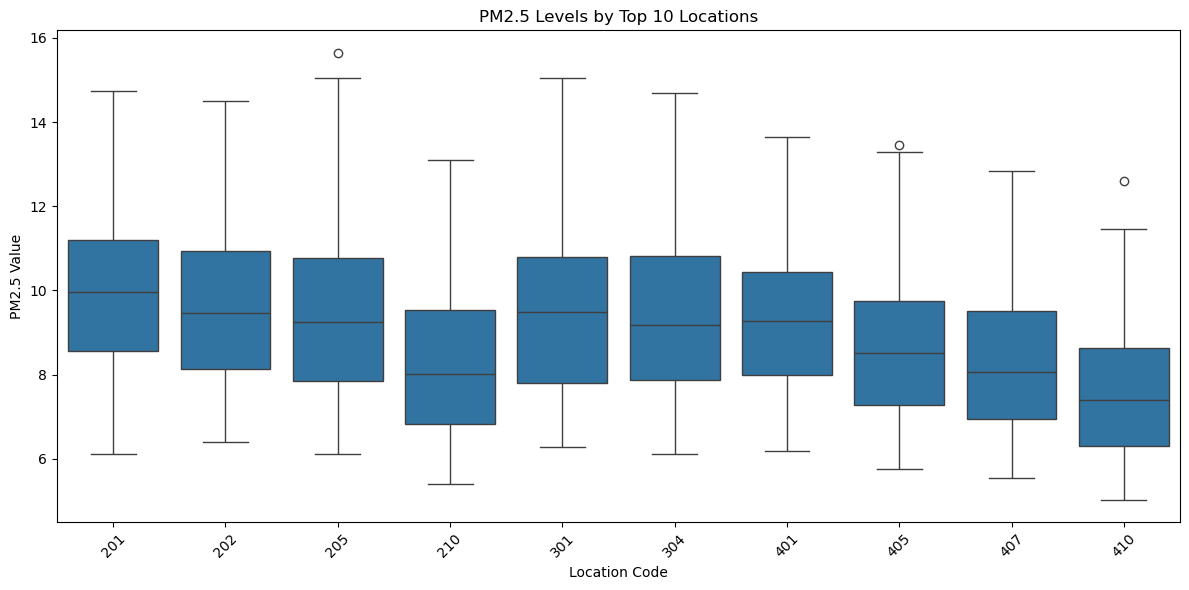

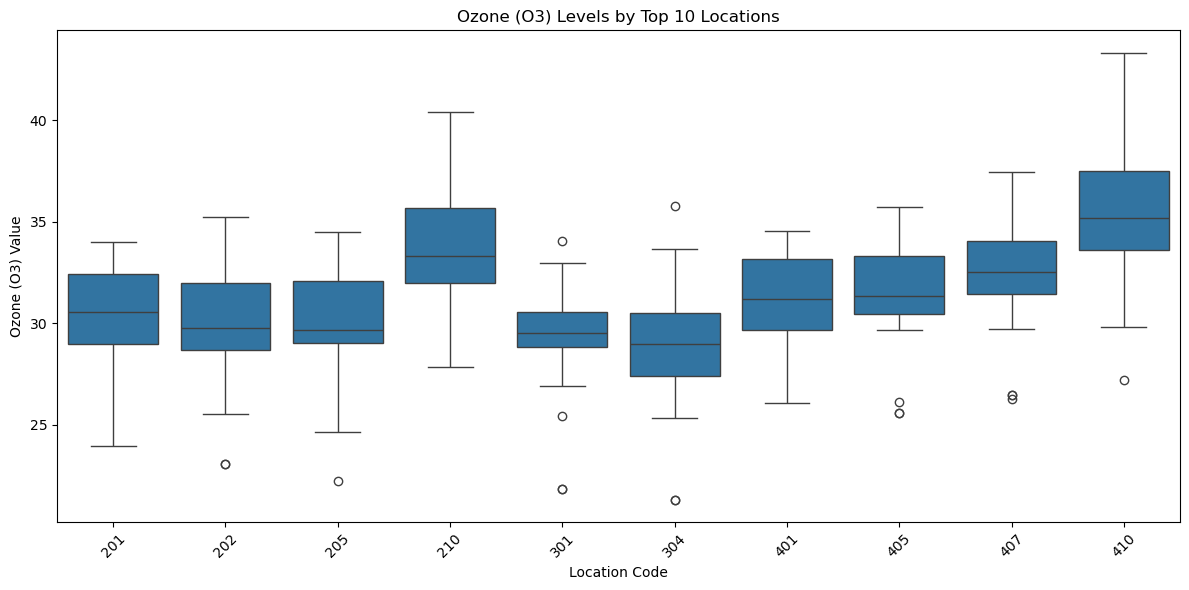

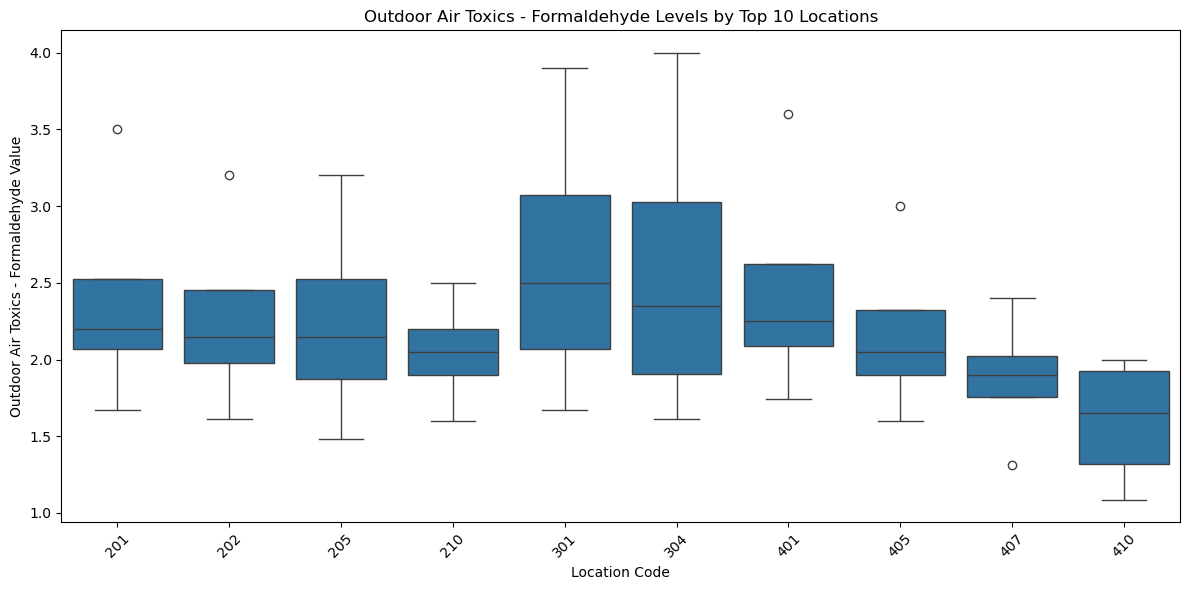

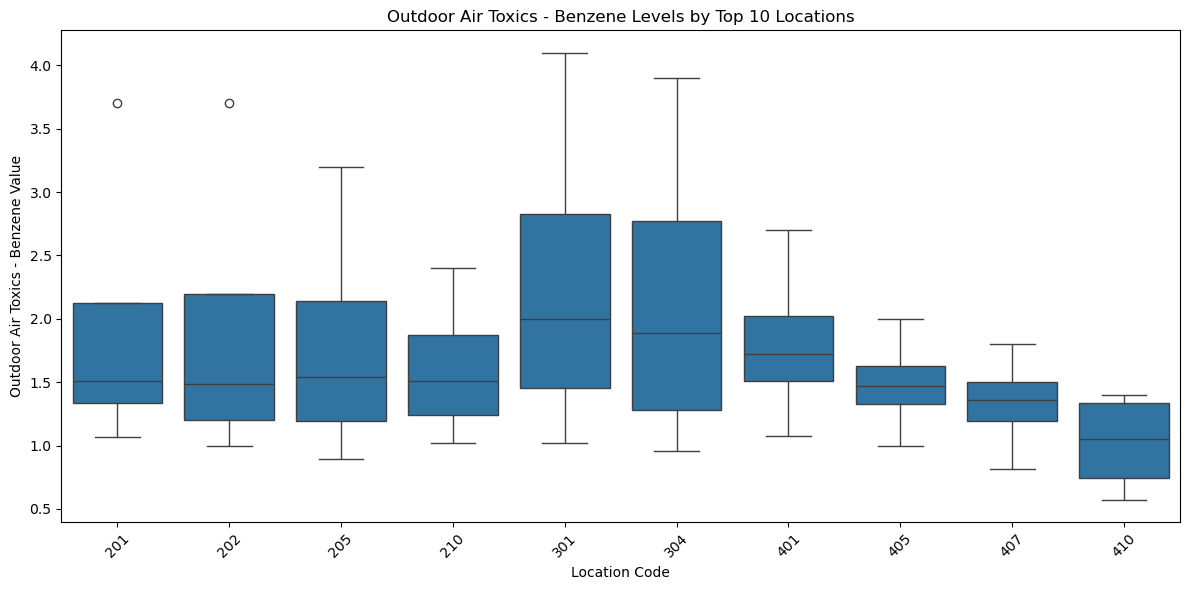

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Find top 10 most frequent locations
top_locations = selected_plot_df['location_code'].value_counts().head(10).index

# Step 2: Filter the DataFrame
filtered_df = selected_plot_df[selected_plot_df['location_code'].isin(top_locations)]

# Step 3: Loop through each pollutant and create box plots
pollutants = filtered_df['pollutant'].unique()

for pollutant in pollutants:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=filtered_df[filtered_df['pollutant'] == pollutant], 
        x='location_code', 
        y='value'
    )
    plt.title(f'{pollutant} Levels by Top 10 Locations')
    plt.xlabel('Location Code')
    plt.ylabel(f'{pollutant} Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [79]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# selected_pollutants = [
#     'NO2', 'PM2.5', 'Boiler Emissions - Total SO2 Emissions', 'Ozone (O3)',
#     'Boiler Emissions - Total NOx Emissions', 'Boiler Emissions - Total PM2.5 Emissions',
#     'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene',
# ]

# # Filter the main dataframe to include only the selected pollutants
# selected_rows = df[df['pollutant_code'] == 643]

# # Merge the dataframes
# merged_df = pd.merge(selected_plot_df, selected_rows, on='year')

# # Check columns in the merged dataframe
# print(merged_df.columns)
# print(merged_df.head())

# # Set up the plot size
# plt.figure(figsize=(14, 10))

# # Create density plots for each pollutant
# for i, pollutant in enumerate(selected_pollutants, 1):
#     plt.subplot(3, 3, i)  # Adjust the grid size based on number of pollutants
#     sns.kdeplot(data=merged_df, x='value_x', y='value_y', fill=True, cmap='viridis', alpha=0.6)
#     plt.title(f'Density of {pollutant} vs Traffic Miles')
#     plt.xlabel('Miles of Traffic')
#     plt.ylabel(f'{pollutant} Level')

# plt.tight_layout()  # Adjust layout for better spacing
# plt.show()


In [80]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'selected_plot_df' is your DataFrame
# # Group by year and pollutant, then compute mean
# selected_pollutants = [
#     'NO2', 'PM2.5', 'Boiler Emissions - Total SO2 Emissions', 'Ozone (O3)',
#     'Boiler Emissions - Total NOx Emissions', 'Boiler Emissions - Total PM2.5 Emissions',
#     'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene','Annual vehicle miles traveled',
# ]

# # Filter the DataFrame
# plot_df = df[df['pollutant'].isin(selected_pollutants)][['year', 'pollutant', 'value']].copy()

# grouped = plot_df.groupby(['year', 'pollutant'])['value'].mean().reset_index()

# # Plot
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=grouped, x='year', y='value', hue='pollutant', marker='o')
# plt.title("Yearly Average Pollutant Levels")
# plt.xlabel("Year")
# plt.ylabel("Mean Concentration")
# plt.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
# plt.xticks(sorted(grouped['year'].unique()))
# plt.tight_layout()
# plt.show()